In [1]:
import os
import random

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision

from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms

from helper_evaluation import set_all_seeds, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import UnNormalize

In [2]:
torch.cuda.empty_cache()
random_seed = 42
train_root = 'train_images'
NUM_EPOCHS = 40
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

set_all_seeds(random_seed)

In [3]:
train_table = pd.read_csv('train.csv')
train_table.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
train_table.shape

(21396, 2)

In [5]:
train_table['label'].value_counts()

3    13158
4     2576
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [6]:
train_paths = [os.path.join(train_root, file) for file in train_table['image_id']]
train_labels = train_table['label'].values

In [7]:
# sizes = set()
# modes = set()
# for path in train_paths:
#     pic = Image.open(path)
#     sizes.add(pic.size)
#     modes.add(pic.mode)
# print(sizes)
# print(modes)

In [8]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
    #transforms.Scale(256),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

def default_loader(path):
    img_pil =  Image.open(path)
    img_pil = img_pil.resize((400,300))
    img_tensor = preprocess(img_pil)
    return img_tensor

In [9]:
class MyDataset(Dataset):
    def __init__(self, img_paths, labels, loader=default_loader):
        self.img_paths = img_paths
        self.labels = labels
        self.loader = loader
        
    def __getitem__(self, index):
        img_path, label = self.img_paths[index], self.labels[index]
        img = self.loader(img_path)
        
        return img, label
    
    def __len__(self):
        return len(self.labels)

In [10]:
dataset = MyDataset(train_paths, train_labels)
len(dataset)*np.array([0.8,0.05,0.15])

array([17116.8,  1069.8,  3209.4])

In [11]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [17117 ,  1070,  3209], generator=torch.Generator().manual_seed(random_seed))

In [12]:
batch_size = 40
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [13]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'shufflenet_v2_x1_0', pretrained=True)
model = model.to(device)

Using cache found in C:\Users\woqip/.cache\torch\hub\pytorch_vision_v0.9.0


In [14]:
optimizer = torch.optim.SGD(model.parameters(), momentum=0.7, lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

Epoch: 001/040 | Batch 0000/0428 | Loss: 8.0353
Epoch: 001/040 | Batch 0100/0428 | Loss: 0.7180
Epoch: 001/040 | Batch 0200/0428 | Loss: 1.1668
Epoch: 001/040 | Batch 0300/0428 | Loss: 0.9072
Epoch: 001/040 | Batch 0400/0428 | Loss: 0.9178
Epoch: 001/040 | Train: 77.62% | Validation: 77.10%
Time elapsed: 8.42 min
Epoch: 002/040 | Batch 0000/0428 | Loss: 0.5382
Epoch: 002/040 | Batch 0100/0428 | Loss: 0.7085
Epoch: 002/040 | Batch 0200/0428 | Loss: 0.3674
Epoch: 002/040 | Batch 0300/0428 | Loss: 1.0374
Epoch: 002/040 | Batch 0400/0428 | Loss: 0.4228
Epoch: 002/040 | Train: 82.41% | Validation: 80.00%
Time elapsed: 18.68 min
Epoch: 003/040 | Batch 0000/0428 | Loss: 0.6444
Epoch: 003/040 | Batch 0100/0428 | Loss: 0.5194
Epoch: 003/040 | Batch 0200/0428 | Loss: 0.4358
Epoch: 003/040 | Batch 0300/0428 | Loss: 0.2895
Epoch: 003/040 | Batch 0400/0428 | Loss: 0.3358
Epoch: 003/040 | Train: 84.84% | Validation: 81.12%
Time elapsed: 28.66 min
Epoch: 004/040 | Batch 0000/0428 | Loss: 0.3443
Epoch

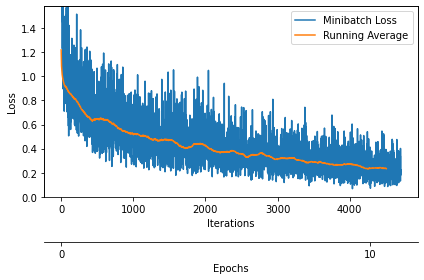

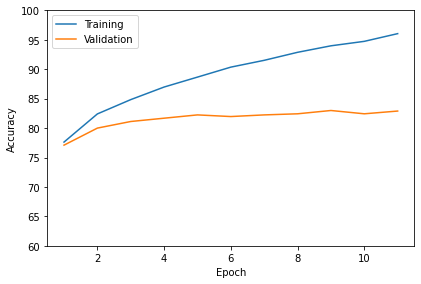

In [15]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

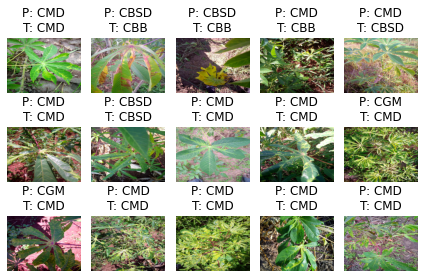

In [16]:
model.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
class_dict = {0: 'CBB',
              1: 'CBSD',
              2: 'CGM',
              3: 'CMD',
              4: 'Healthy'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

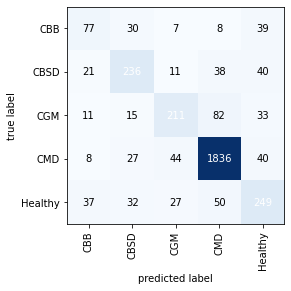

In [17]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

In [18]:
torch.save(model.state_dict(), 'FILENAME')